<a href="https://colab.research.google.com/github/mahrukh98/incredible-AI/blob/master/color_distribution_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline:

Mask RCNN for instance segmentation and masks --> GrabCut for improved segmentation and foreground extraction --> Color Distribution from forefround

This article worked as starting point: https://ai.stackexchange.com/questions/24648/how-to-compute-dominant-colors-in-an-image

Please access the images folder here https://drive.google.com/drive/folders/1znGu4Ejc0TNNmgePxftPh0KHVmp_FUhj?usp=sharing 

Add it to your drive at root

Mount the drive and follow along.

In [ ]:
# mount drive for image(s) data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports and Dependencies

In [ ]:
# clone Mask RCNN repository for instance based segmentation
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
# focus directory with concerned COCO dataset
import os
os.chdir("Mask_RCNN/samples")

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import sys
import PIL
from PIL import Image
import random
import math
import numpy as np
import pandas as pd
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

In [ ]:
# setting versions according to Mask RCNN requirements/dependencies need uninstalling those pre-installed on Colab
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Successfully uninstalled keras-2.9.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0


In [ ]:
# refer: https://github.com/matterport/Mask_RCNN/blob/master/requirements.txt
# might be possible to encounter "restart runtime" message after running this cell, 
# in that case restart runtime and run each cell from start except this one

!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0


# following for color distribution 
!pip install extcolors
!pip install colormap
!pip install easydev


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.3 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
     |████████████████████████████████| 42 kB 520 kB/s 
     |████████████████████████████████| 3.2 MB 6.9 MB/s 
     |████████████████████████████████| 367 kB 46.7 MB/s 
     |████████████████████████████████| 4.1 MB 41.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormap: filename=colormap-1.0.4-py3-none-any.whl size=15637 sha256=a45cfd2368f5f3d7a27a7653a9272cab1ada078a4c5c1962b288e39fbc337874
  Stored in directory: /root/.cache/pip/wheels/71/35/4b/259c328e39ede29b184e4ffe4443bcc2be4e475178a83794c3
Successfully built colormap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.3 MB/s 
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64231 sha256=c1cce851219f66ced940dcc5cad03ef8bf6138945cf43804805b21b9435a22d8
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built easydev


In [ ]:
# color distribution
import matplotlib.patches as patches
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import extcolors

from colormap import rgb2hex

In [ ]:
### This cell is taken from Mask RCNN official repository
### refer: https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

##### where all images and masks are stored
PATH_CONVERSION_DIR ='./'

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = "/content/drive/MyDrive/images_dir"

Using TensorFlow backend.


... done downloading pretrained model!


## Configurations

In [ ]:
### This cell is taken from Mask RCNN official repository
### refer: https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb 

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [ ]:
### This cell is taken from Mask RCNN official repository
### refer: https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


## Initializing Class Names
Limited # of classes for segmentation as downloading whole dataset would need alot of memory!

In [ ]:
### This cell is taken from Mask RCNN official repository
### refer: https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Object Detection in Action

Processing 1 images
image                    shape: (400, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


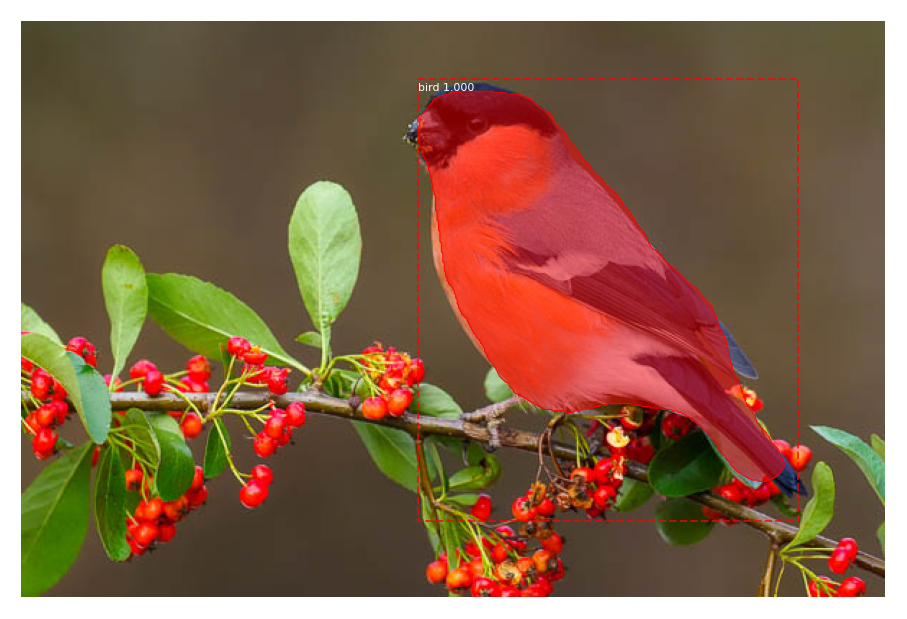

In [ ]:
# Load a random image from the images folder
file_names = []
test_images_path = os.path.join(IMAGE_DIR, "test_images")
for root, dir, files in os.walk(test_images_path):
  for file in files:
    file_names.append(file)

image_path = os.path.join(test_images_path, random.choice(file_names))
image = skimage.io.imread(image_path)


# input_file_path = os.path.join(IMAGE_DIR, "chakor.jpg")
# image = skimage.io.imread(input_file_path)


# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [ ]:
# creating bitmaps or alpha channel masks

detected_regions = []
masks = r['masks']
instance_name = os.path.basename(image_path.split('.')[0])
bitmaps_dir = "/content/drive/MyDrive/images_dir/bitmaps"

for ix, class_id in enumerate(r['class_ids']):
  # label = class_names[class_id].replace(' ', _)
  # confidence_score = int(r['scores'][ix] * 100)
  # (y1, x1, y2, x2) = r['rois'][ix]
  # width = x2 - x1
  # height = y2 - y1
  # would work in case of multiple instances but for the sake of simplicity (in terms of resources)
  # i've taken images with only one instance/class and object 
  computed_mask = masks[:,:,ix]
  computed_mask[computed_mask > 0] = 255
  bitmap_path = os.path.join(bitmaps_dir, instance_name + "_bitmap.png")
  plt.imsave(bitmap_path, computed_mask, cmap='gray')
  

In [ ]:
masks_dir = "/content/drive/MyDrive/images_dir/masks"
mask_path = os.path.join(masks_dir, instance_name +"_mask.jpg")
plt.imsave(mask_path, r['masks'][:,:,0].astype("uint8"), cmap = 'gray')

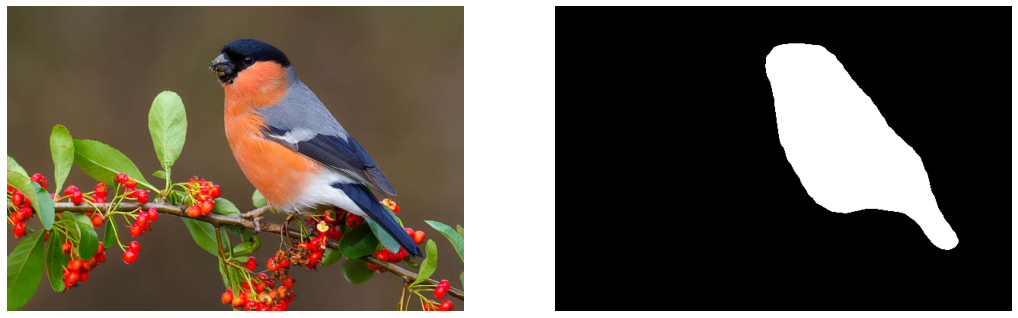

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[1].axis('off')
ax[0].figure.set_size_inches(18,10)
ax[1].figure.set_size_inches(18,10)

ax[0].imshow(image)
ax[1].imshow(r['masks'][:,:,0], cmap="gray")

In [ ]:
# extract region, crop it match the region mask 
mask_region = cv2.imread(mask_path)
(y1, x1, y2, x2) = r['rois'][0]
width = x2 - x1
height = y2 - y1
(x, y, w, h) = x1, y1, width, height

print(f'(x, y, w, h): {(x, y, w, h)}')
extracted_image = cv2.bitwise_and(image, mask_region)
print(f'extracted_image: {extracted_image.shape}')
cropped_extracted_image = extracted_image[y:y+h, x:x+w]
print(f'cropped_extracted_image: {cropped_extracted_image.shape}')
result_image = cv2.resize(cropped_extracted_image, (w, h))
print(f'result_image: {result_image.shape}')
result_dir = '/content/drive/MyDrive/images_dir/results'
result_path = os.path.join(result_dir, instance_name + "_result.jpg")
plt.imsave(result_path, result_image)

(x, y, w, h): (275, 40, 264, 307)
extracted_image: (400, 600, 3)
cropped_extracted_image: (307, 264, 3)
result_image: (307, 264, 3)


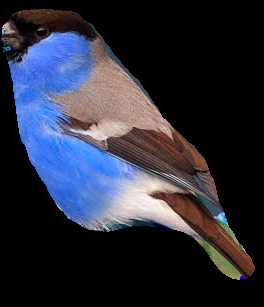

In [ ]:
cv2_imshow(result_image)

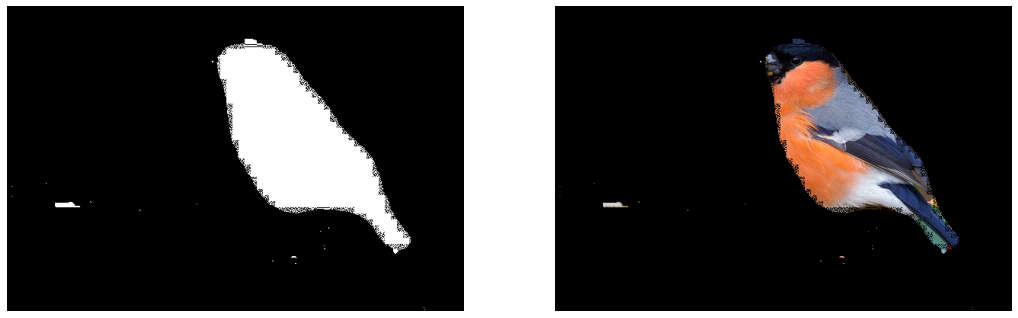

In [ ]:
detected_mask = cv2.imread(mask_path, 0)
init_mask = detected_mask.copy()
gb_mask = np.zeros(image.shape[:2],np.uint8)
gb_mask[init_mask == 255] = 1
gb_mask[init_mask == 0] = 2 # background



bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

gb_mask, bgdModel, fgdModel = cv2.grabCut(image, gb_mask, None, bgdModel, fgdModel, iterCount=5, mode=cv2.GC_INIT_WITH_MASK)
final_mask = np.where((gb_mask == 2) | (gb_mask == 0), 0, 1 ).astype('uint8')

final_mask[final_mask == 1] = 255
final_result = cv2.bitwise_and(image, image, mask=final_mask)


fig, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[1].axis('off')
ax[0].figure.set_size_inches(18,10)
ax[1].figure.set_size_inches(18,10)

ax[0].imshow(final_mask, cmap="gray")
ax[1].imshow(final_result)

gb_results_path = os.path.join(result_dir, instance_name + "_gb_result.jpg")
plt.imsave(gb_results_path, final_result)

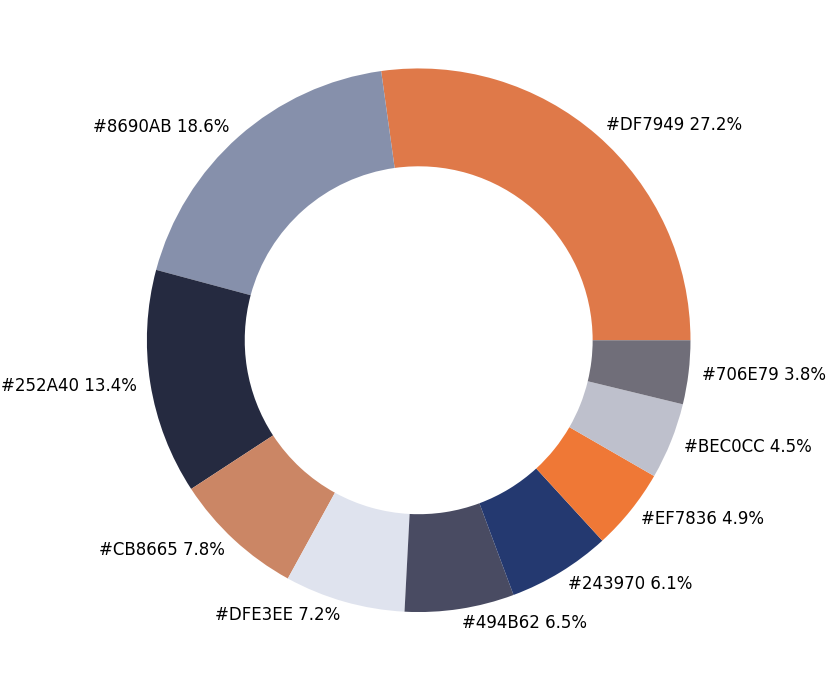

In [ ]:
# Adapted from: https://towardsdatascience.com/image-color-extraction-with-python-in-4-steps-8d9370d9216e
colors_x = extcolors.extract_from_path(gb_results_path, tolerance = 12, limit = 12)

def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[1:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df

df_color = color_to_df(colors_x)

list_color = list(df_color['c_code'])
list_precent = [int(i) for i in list(df_color['occurence'])]
text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color,
                                                                               list_precent)]
fig, ax = plt.subplots(figsize=(90,90),dpi=10)
wedges, text = ax.pie(list_precent,
                      labels= text_c,
                      labeldistance= 1.05,
                      colors = list_color,
                      textprops={'fontsize': 120, 'color':'black'}
                     )
plt.setp(wedges, width=0.3)

#create space in the center
plt.setp(wedges, width=0.36)

ax.set_aspect("equal")
fig.set_facecolor('white')
plt.show()